# Tutorial 4: Human Breast Cancer Dataset

This tutorial illustrates how to apply S3RL to the Human Breast Cancer dataset from 10X Genomics (Visium platform). The dataset can be accessed at [10X Genomics Portal](https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0), and includes gene expression, spatial coordinates, and H&E-stained images.

After preprocessing, S3RL enhances the spatial gene expression structure and reveals distinct tissue compartments such as tumor, stromal, and immune-rich regions. Spatial patterns of key marker genes like CXCL14 and DDR1 become more sharply localized, aiding in tumor microenvironment analysis.

In [ ]:
import scanpy as sc
import os
import cv2
from S3RL.process_data import process_data
import pandas as pd
import numpy as np

path = '../Data'
dataset = 'Human_Breast_Cancer'
id = '' 
knn = 5
pixel_size = 10
path_semantic_fea = '../Img_encoder/models/'

adata = sc.read_h5ad(os.path.join(path, dataset, id, 'sampledata.h5ad'))
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000, check_values=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Ann_df = pd.read_csv(os.path.join(path, dataset, id, 'annotation.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
drop = Ann_df.loc[adata.obs_names, 'Ground Truth'].isna()
adata = adata[~drop]
adata = adata[:, adata.var['highly_variable']]

image = cv2.imread(os.path.join(path, dataset, id, 'spatial/tissue_hires_image.png'))
semantic_fea = np.load(os.path.join(path_semantic_fea, dataset, id, 'img_emb.npy'))

adata = process_data(adata, image, pixel=pixel_size, knn=knn, semantic_fea=semantic_fea)

In [3]:
from S3RL.model import S3RL
import yaml
import torch
from sklearn.metrics import adjusted_rand_score

device = torch.device("cuda:0")
C = len(set(Ann_df[Ann_df['Ground Truth'].notna()]['Ground Truth'].values.tolist()))
cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, dataset+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

model = S3RL(adata, n_clu=C, device=device, **cfg)

adata = model.train()

Training the S3RL model:  93%|█████████▎| 1388/1500 [01:12<00:05, 19.13it/s]

Reached the tolerance, early stop training at epoch 1388


In [4]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
ground_truth = adata.obs['Ground Truth'].astype('category').cat.codes.values
print('ARI is', adjusted_rand_score(ground_truth, adata.obs['pred']))

ARI is 0.672327896923898


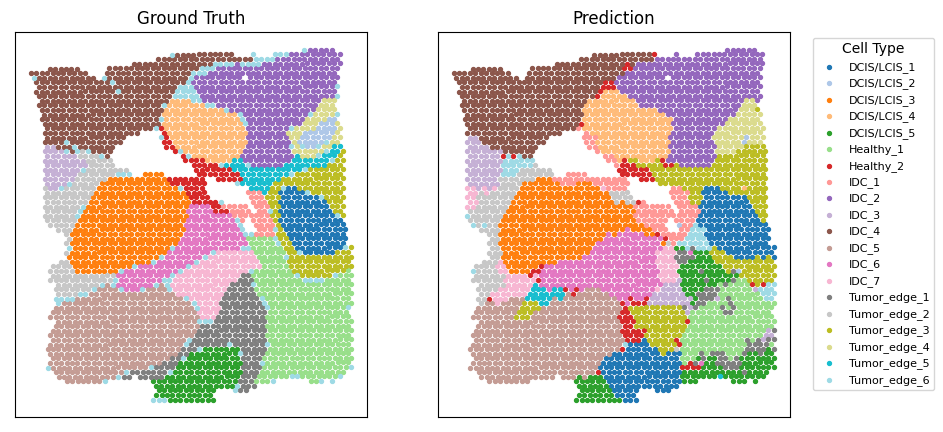

In [5]:
import matplotlib
from S3RL.tools import hungarian_match
import numpy as np
import matplotlib.pyplot as plt

label_pred = hungarian_match(ground_truth, adata.obs['pred'])
label_dict = dict(zip(ground_truth, adata.obs['Ground Truth'].values))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

colors = np.vstack([np.array(matplotlib.colormaps['tab20'].colors), 
                    np.array(matplotlib.colormaps['tab20b'].colors), 
                    np.array(matplotlib.colormaps['tab20c'].colors)])

for i in set(ground_truth):
    axs[0].scatter(adata.obsm['spatial'][ground_truth==i, 0], adata.obsm['spatial'][ground_truth==i, 1], color=colors[i], s=8)
    axs[1].scatter(adata.obsm['spatial'][label_pred==i, 0], adata.obsm['spatial'][label_pred==i, 1], color=colors[i], s=8, label=label_dict[i])

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('Ground Truth')
axs[1].set_title('Prediction')

plt.show()